## Machine Learning to Classify Autistic Childrens Based on Facial Images

In [1]:
import sys
print(f"Python version is {sys.version}")
import os
import numpy as np
import random
from PIL import Image
import cv2
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import warnings
warnings.filterwarnings("ignore", message="Your `PyDataset` class should call `super().__init__")
import tensorflow as tf
print(f"tensorflow version is {tf.__version__}")

Python version is 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
tensorflow version is 2.19.0


Image data shape: (2940, 128, 128, 3)
Labels shape: (2940,)
Data import completed. It totally takes 6.302609920501709 seconds.


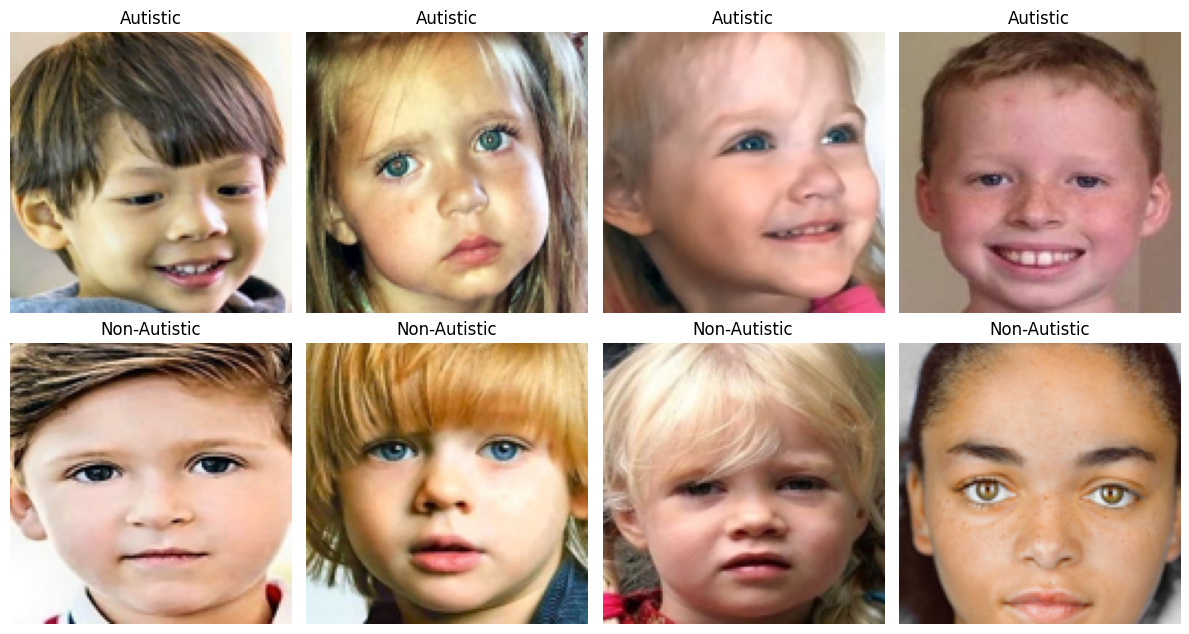

In [2]:
# import data
images = []
labels = []
data_dir = 'autism_face_library'
IMG_SIZE = (128, 128) 

Start = time.time()
for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
        filepath = os.path.join(data_dir, filename)
        if filename.startswith('Autistic'):
            label = 1 # ASD kids labeled 1
        elif filename.startswith('Non_Autistic'):
            label = 0 # Non-ASD kids labeled 0
        else:
            continue   
        try:
            img = Image.open(filepath).convert('RGB')
            img = img.resize(IMG_SIZE) # standardize the image size to (128, 128)
            img_array = np.array(img)

            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")

# Convert data lists to Arrays
X = np.array(images)
y = np.array(labels)
print("Image data shape:", X.shape)
print("Labels shape:", y.shape)
print(f"Data import completed. It totally takes {time.time() - Start} seconds.")

# show example images
plt.figure(figsize=(12, 6.5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X[i*368+6])
    plt.title("Autistic" if y[i*368+6] == 1 else "Non-Autistic")
    plt.axis('off')

plt.tight_layout()
plt.savefig("Figure_A Example Facial Images.png", dpi=300, bbox_inches='tight')
plt.show()

### VGG16 Model Fitting and Evaluation

In [3]:
# ensure reproducibility
SEED = 50
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Preparing the format of labels: One-hot encode labels 
# binary classification: 0 = Non-Autistic, 1 = Autistic
y_cat = to_categorical(y, num_classes=2)

# Preprocess input for VGG16 required format
X_prep = preprocess_input(X)

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_prep, y_cat, test_size=0.2, stratify=y, random_state=SEED)

In [4]:
# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers:
    if layer.name.startswith('block5'):
        layer.trainable = True
    
# Create new model on top
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# x = base_model(inputs, training=False)
x = base_model(inputs, training=True) # changed training = True since block5 is unfrozen
x = GlobalAveragePooling2D()(x) # Better than Flatten for transfer learning
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x) # 2 classes

model = Model(inputs, outputs)

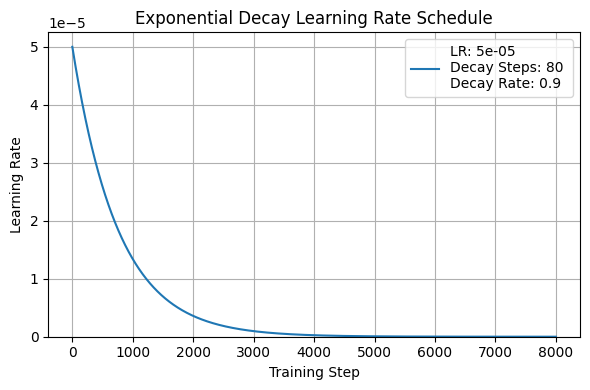

In [5]:
# # Constant Learning Rate
# model.compile(optimizer=Adam(learning_rate=1e-5),
#               loss='categorical_crossentropy',
#               metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# ------------------------------------------------------------------------
# Exponential Decay Scheduler Learning Rate
initial_lr = 5e-5
decay_rate = 0.9 
decay_steps = 80
lr_schedule = ExponentialDecay(initial_learning_rate = initial_lr,
                               decay_steps = decay_steps,
                               decay_rate = decay_rate,
                               staircase = False) # staircase=True: Discrete drop every 300 steps
                                                # staircase = False: continuous decay at every step

model.compile(optimizer=Adam(learning_rate=lr_schedule),  
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

steps = np.arange(0, 8001)
lrs = [lr_schedule(step).numpy() for step in steps]

plt.figure(figsize=(6, 4))
plt.plot(steps, lrs, label=f'LR: {initial_lr} \nDecay Steps: {decay_steps} \nDecay Rate: {decay_rate}')
plt.title('Exponential Decay Learning Rate Schedule')
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------
# # Learning rate scheduling
# initial_learning_rate = 0.0001
# lr_schedule = ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=10000,
#     decay_rate=0.96,
#     staircase=True)

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=lr_schedule),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [6]:
# Train model with early stopping
# # early stopping by val_loss (default)
# early_stop = EarlyStopping(patience=15, restore_best_weights=True)
# # early stopping by val_accuracy
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, mode='max', restore_best_weights=True)

class PrintLearningRate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            current_lr = lr(self.model.optimizer.iterations).numpy()
        else:
            current_lr = lr.numpy()
        print(f"\nEpoch {epoch + 1}: Learning rate = {current_lr:.8f}")

Start = time.time()

history = model.fit(
    X_train, y_train,
    validation_split = 0.2, # take 20% of the training data and use it as a validation set during training
    epochs = 200,
    batch_size = 64,
    callbacks=[PrintLearningRate(), early_stop],
    verbose = 1
)

print(f"\nModel fitting completed. It totally takes {time.time() - Start} seconds.")

model.save('5LOSS.keras')

val_acc = history.history['val_accuracy']
print("\nBest validation accuracy:", max(val_acc))

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5099 - loss: 2.9713 - precision: 0.5099 - recall: 0.5099
Epoch 1: Learning rate = 0.00004806
30/30 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.5117 - loss: 2.9211 - precision: 0.5117 - recall: 0.5117 - val_accuracy: 0.6900 - val_loss: 0.6040 - val_precision: 0.6900 - val_recall: 0.6900
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6557 - loss: 0.6169 - precision: 0.6557 - recall: 0.6557
Epoch 2: Learning rate = 0.00004620
30/30 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.6564 - loss: 0.6160 - precision: 0.6564 - recall: 0.6564 - val_accuracy: 0.6921 - val_loss: 0.5765 - val_precision: 0.6921 - val_recall: 0.6921
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7301 - loss: 0.5349 - precision: 0.7301 - recall: 0.7301
Epoch 3: Learning rate = 0.00004441
30/30 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.7306 - loss: 0.5339 - precision: 0.7306 - recall: 0.7306 - val_accuracy: 0.7473

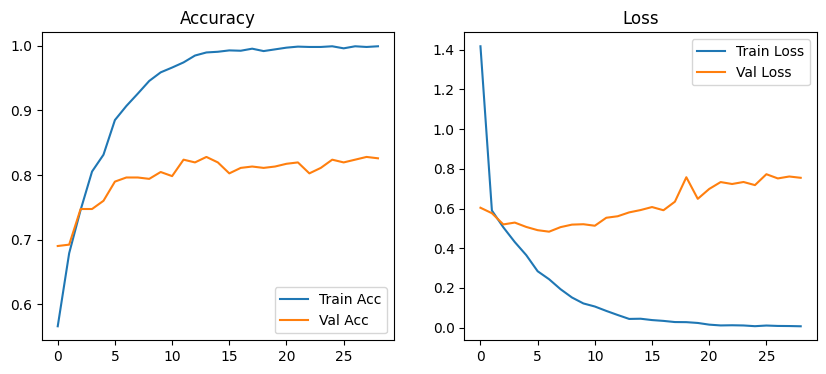

In [7]:
# Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [8]:
# Evaluate on test set
# model = tf.keras.models.load_model('4LOSS.keras')
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict class probabilities
y_prob = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_prob, axis=1)

label_map = {0: 'Non-Autistic', 1: 'Autistic'}
class_names = [label_map[i] for i in range(len(label_map))]

print(classification_report(y_true, y_pred, target_names=class_names))

19/19 - 28s - 1s/step - accuracy: 0.8129 - loss: 0.5873 - precision: 0.8129 - recall: 0.8129
Test Accuracy: 0.8129
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
              precision    recall  f1-score   support

Non-Autistic       0.78      0.86      0.82       294
    Autistic       0.85      0.76      0.80       294

    accuracy                           0.81       588
   macro avg       0.82      0.81      0.81       588
weighted avg       0.82      0.81      0.81       588



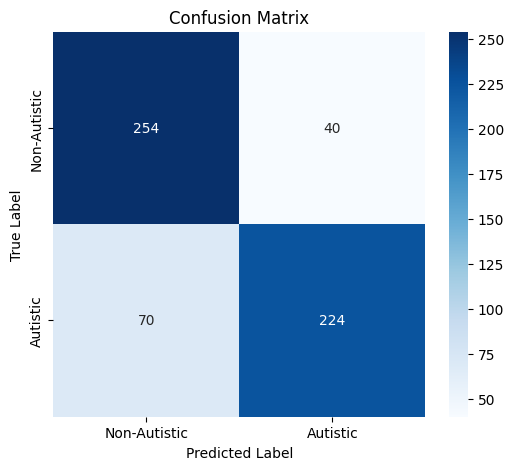

In [9]:
# Confusion matrix on test set
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

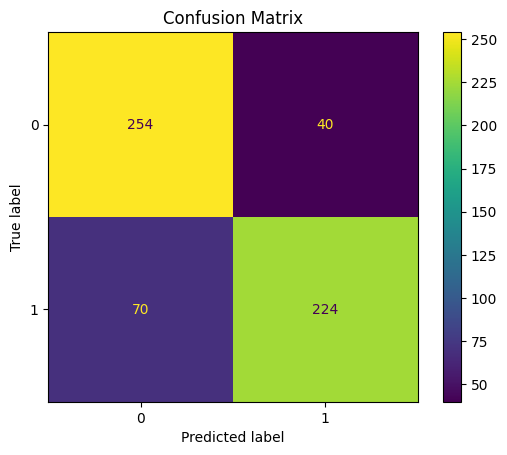

In [10]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

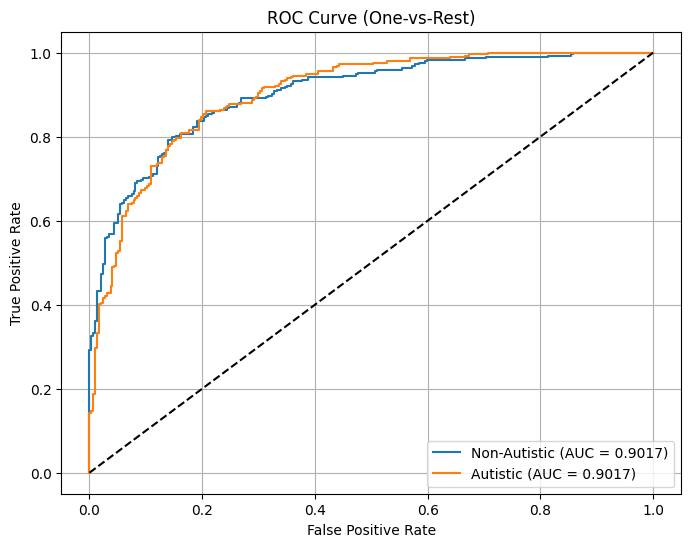

In [11]:
# ROC Curve
n_classes = y_test.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [12]:
def overlay_heatmap(img, activation_map, alpha=0.4, colormap='jet'):
    import matplotlib.cm as mpl_cm  # make sure we use the right cm
    # Normalize activation map
    activation_norm = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min() + 1e-8)
    cmap = mpl_cm.get_cmap(colormap)
    heatmap = cmap(activation_norm)
    heatmap = np.delete(heatmap, 3, 2)  # Remove alpha channel    
    # Ensure img in [0,1]
    img_norm = img / 255.0   
    # Blend heatmap with original image
    overlayed = heatmap * alpha + img_norm * (1 - alpha)
    return np.clip(overlayed, 0, 1) 
    
def visualize_activation_maps(model, img_array, layer_name='block5_conv3'):
    import numpy as np
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    import cv2

    activation_model = Model(inputs=model.inputs,
                             outputs=model.get_layer(layer_name).output)
    img_tensor = np.expand_dims(img_array, axis=0)
    activations = activation_model.predict(img_tensor)
    avg_activation = np.mean(activations[0], axis=-1)

    # Upsample activation map to image size
    upsampled_activation = cv2.resize(avg_activation, 
                                     (img_array.shape[1], img_array.shape[0]), 
                                     interpolation=cv2.INTER_LINEAR)

    # Enhance low activation differences with sqrt transform
    epsilon = 1e-6
    activation_sqrt = np.sqrt(upsampled_activation + epsilon)

    # Percentile clipping for contrast stretching
    low_p = np.percentile(activation_sqrt, 5)
    high_p = np.percentile(activation_sqrt, 95)
    activation_clipped = np.clip(activation_sqrt, low_p, high_p)
    activation_norm = (activation_clipped - low_p) / (high_p - low_p + 1e-8)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

    # Original image
    axes[0].imshow(img_array)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Activation map (enhanced) + colorbar
    im = axes[1].imshow(activation_norm, cmap='jet')
    axes[1].set_title('Activation Map (enhanced)')
    axes[1].axis('off')
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    # Overlay heatmap on image using enhanced activation_norm
    overlayed_img = overlay_heatmap(img_array, activation_norm, alpha=0.4, colormap='jet')
    axes[2].imshow(overlayed_img)
    axes[2].set_title('Overlayed Activation Map')
    axes[2].axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

Sample Prediction: Autistic
True Label: Autistic
Confidence: 84.72%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


C:\Users\A66702\AppData\Local\Temp\ipykernel_20224\4054443805.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl_cm.get_cmap(colormap)


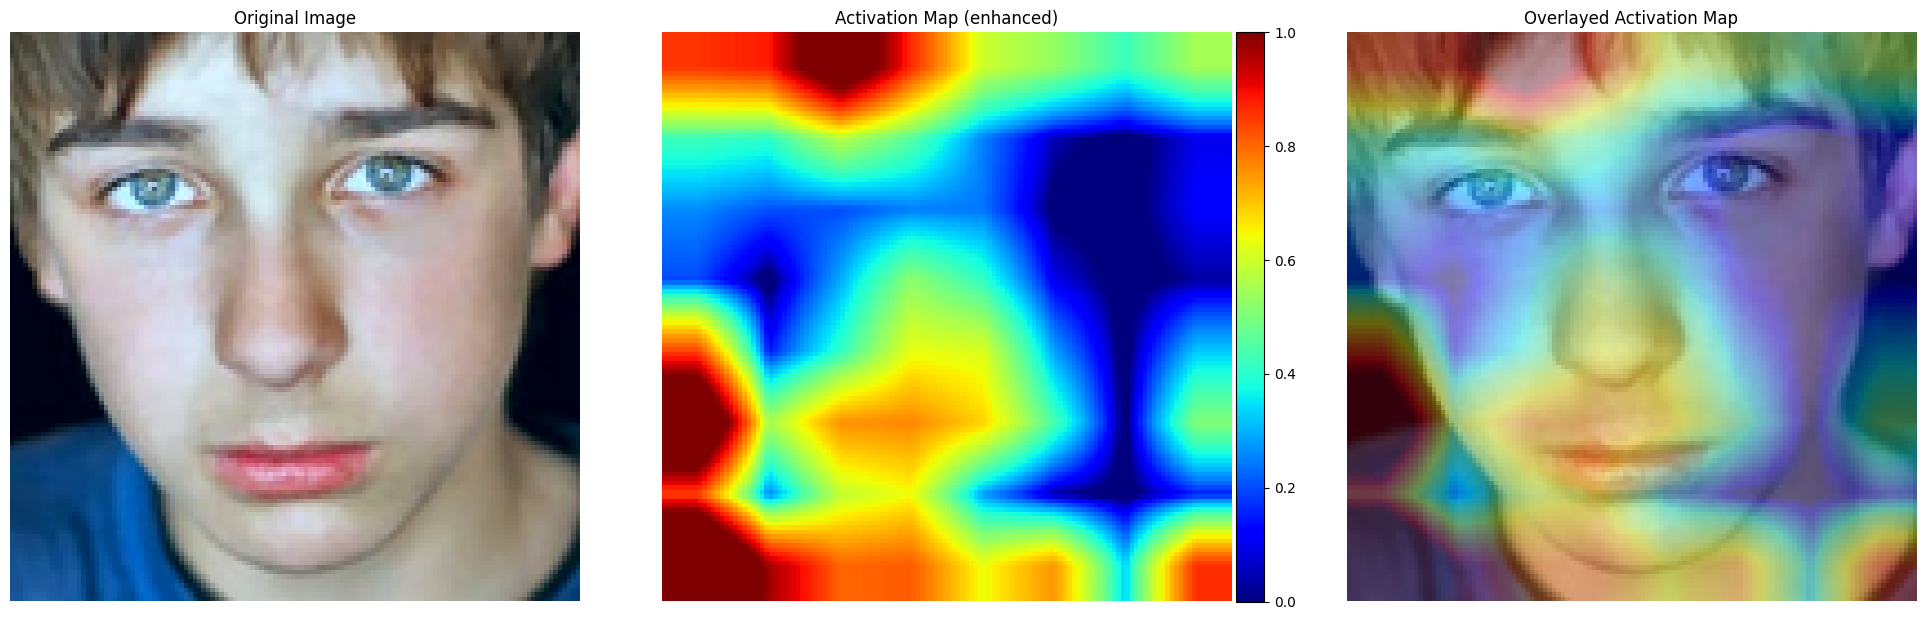

In [13]:
# sample_idx = np.random.randint(0, len(X_test))
sample_idx = 18
sample_img = X_test[sample_idx]
sample_img_vis = sample_img.copy()
sample_img_vis = sample_img_vis[..., ::-1] # BGR to RGB
sample_img_vis[..., 0] += 103.939 # Zero-centering reversal
sample_img_vis[..., 1] += 116.779
sample_img_vis[..., 2] += 123.68
sample_img_vis = np.clip(sample_img_vis, 0, 255).astype('uint8')

# Print the prediction for this sample
sample_pred = model.predict(np.expand_dims(sample_img, axis=0))
pred_class = np.argmax(sample_pred)
true_class = np.argmax(y_test[sample_idx])
print(f"\nSample Prediction: {'Autistic' if pred_class == 1 else 'Non-Autistic'}")
print(f"True Label: {'Autistic' if true_class == 1 else 'Non-Autistic'}")
print(f"Confidence: {np.max(sample_pred)*100:.2f}%")

visualize_activation_maps(base_model, sample_img_vis)